In [38]:
"""
数列を0~1の範囲に正規化する

それぞれの数値は数直線0~1の、
どのあたりにあるかという数値に変換されるイメージだ。
"""
function normalize_minmax_inverse(data)
    (1 .- (data .- minimum(data)) ./ (maximum(data) - minimum(data))) .^8
end

data = [1,1.5,2,3,8,10]
normalize_minmax_inverse(data)

6-element Vector{Float64}:
 1.0
 0.6330111067903695
 0.3897443431289457
 0.13391963118398728
 5.947026720107203e-6
 0.0

In [39]:
using CSV, DataFrames
df = CSV.read("../data/race.csv", DataFrame)

Row,race,horse,box,odds,trainer,jockey,margin
,String,String31,Int64,Float64,String31,String15,String15
1,11R_第13回アルテミスステークス(GIII),ブラウンラチェット,2,4.7,[東] 手塚貴久,ルメール,0
2,11R_第13回アルテミスステークス(GIII),ミストレス,1,15.6,[西] 矢作芳人,坂井瑠星,1.1/4
3,11R_第13回アルテミスステークス(GIII),ショウナンザナドゥ,8,4.1,[西] 松下武士,池添謙一,1.1/4
4,11R_第13回アルテミスステークス(GIII),シホリーン,4,6.6,[東] 武井亮,菅原明良,1.3/4
5,11R_第13回アルテミスステークス(GIII),マイエレメント,3,6.3,[西] 福永祐一,横山武史,2
6,11R_第13回アルテミスステークス(GIII),カムニャック,10,3.1,[西] 友道康夫,川田将雅,2.1/4
7,11R_第13回アルテミスステークス(GIII),マピュース,6,57.9,[東] 和田勇介,田辺裕信,3
8,11R_第13回アルテミスステークス(GIII),クレオズニードル,11,79.9,[東] 和田勇介,津村明秀,4.1/4
9,11R_第13回アルテミスステークス(GIII),ミリオンローズ,5,13.4,[東] 萩原清,戸崎圭太,5.1/4


In [40]:
# 着差の表示
for margin in df.margin
    println(margin)
end


0
1.1/4
1.1/4
1.3/4
2
2.1/4
3
4.1/4
5.1/4
5.3/4
6
0
1/2
4
1
2
アタマ
1.1/4
2.1/2
1.1/4
3/4
1.3/4
3/4
0
1.1/4
クビ
アタマ
1/2
1.1/2
1.1/4
2
1
1/2
2


In [41]:
function margin_to_slit(margin::AbstractString)
    # 特殊な表記の処理
    special_cases = Dict(
        "同着" => 0,
        "ハナ" => 3,
        "アタマ" => 6,
        "クビ" => 12,
        "大差" => 360
    )

    if haskey(special_cases, margin)
        return special_cases[margin]
    end

    try
        # 数値のみの場合（"1", "2" など）
        if occursin(r"^\d+$", margin)
            horse_lengths = parse(Float64, margin)
            return round(Int, 33 * horse_lengths)
        end

        # 分数のみの場合（"1/2", "3/4" など）
        if occursin(r"^\d+/\d+$", margin)
            numerator, denominator = split(margin, "/")
            horse_lengths = parse(Float64, numerator) / parse(Float64, denominator)
            return round(Int, horse_lengths * 33)
        end

        # 整数+分数の場合（"1.1/4", "2.1/2" など）
        if occursin(r"^\d+\.\d+/\d+$", margin)
            whole_part, frac_part = split(margin, ".")
            numerator, denominator = split(frac_part, "/")

            horse_lengths = parse(Float64, whole_part) +
                          parse(Float64, numerator) / parse(Float64, denominator)

            return round(Int, 33 * horse_lengths)
        end

    catch e
        @warn "未知の形式: $margin"
        return 0
    end

    @warn "パターンにマッチしない着差: $margin"
    return 0
end

# テスト
test_margins = ["1", "1.1/4", "2.1/2", "3/4", "ハナ", "10", "大差", "2.1/4"]
for margin in test_margins
    println("$margin => $(margin_to_slit(margin))")
end

1 => 33
1.1/4 => 41
2.1/2 => 82
3/4 => 25
ハナ => 3
10 => 330
大差 => 360
2.1/4 => 74


In [42]:
# 着差をスリット数に変換する
df.slits = [margin_to_slit(margin) for margin in df.margin]

34-element Vector{Int64}:
   0
  41
  41
  58
  66
  74
  99
 140
 173
 190
   ⋮
  12
   6
  16
  50
  41
  66
  33
  16
  66

In [43]:
# スリットスコアは少ないほど評価が高くなるべきなので逆転処理
df.slit_score = normalize_minmax_inverse(df.slits)

34-element Vector{Float64}:
 1.0
 0.15627003059565464
 0.15627003059565464
 0.06247449630229562
 0.039018442310623416
 0.02366202774216565
 0.00390625
 5.4212873396269264e-5
 6.459494715636835e-8
 7.1022895494003645e-12
 ⋮
 0.6064318906888626
 0.7817867535191608
 0.5096236591278346
 0.0974478363986969
 0.15627003059565464
 0.039018442310623416
 0.23256803936137793
 0.5096236591278346
 0.039018442310623416

In [44]:
df

Row,race,horse,box,odds,trainer,jockey,margin,slits,slit_score
,String,String31,Int64,Float64,String31,String15,String15,Int64,Float64
1,11R_第13回アルテミスステークス(GIII),ブラウンラチェット,2,4.7,[東] 手塚貴久,ルメール,0,0,1.0
2,11R_第13回アルテミスステークス(GIII),ミストレス,1,15.6,[西] 矢作芳人,坂井瑠星,1.1/4,41,0.15627
3,11R_第13回アルテミスステークス(GIII),ショウナンザナドゥ,8,4.1,[西] 松下武士,池添謙一,1.1/4,41,0.15627
4,11R_第13回アルテミスステークス(GIII),シホリーン,4,6.6,[東] 武井亮,菅原明良,1.3/4,58,0.0624745
5,11R_第13回アルテミスステークス(GIII),マイエレメント,3,6.3,[西] 福永祐一,横山武史,2,66,0.0390184
6,11R_第13回アルテミスステークス(GIII),カムニャック,10,3.1,[西] 友道康夫,川田将雅,2.1/4,74,0.023662
7,11R_第13回アルテミスステークス(GIII),マピュース,6,57.9,[東] 和田勇介,田辺裕信,3,99,0.00390625
8,11R_第13回アルテミスステークス(GIII),クレオズニードル,11,79.9,[東] 和田勇介,津村明秀,4.1/4,140,5.42129e-5
9,11R_第13回アルテミスステークス(GIII),ミリオンローズ,5,13.4,[東] 萩原清,戸崎圭太,5.1/4,173,6.45949e-8


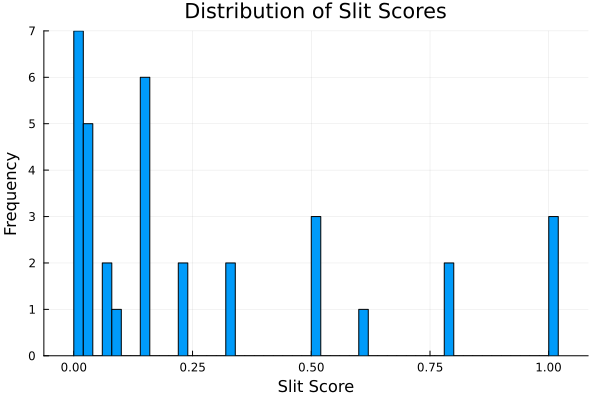

In [45]:
using Plots

# ヒストグラムを作成
histogram(df.slit_score,
    bins=50,  # ビンの数
    title="Distribution of Slit Scores",
    xlabel="Slit Score",
    ylabel="Frequency",
    legend=false
)

In [46]:
# marginの出現頻度をカウント
using StatsBase
margin_counts = countmap(df.margin)

# 着差の値を表示して確認
println("全ての着差の値:")
for (margin, count) in margin_counts
    println("$margin: $count")
end

ArgumentError: ArgumentError: Package StatsBase not found in current path.
- Run `import Pkg; Pkg.add("StatsBase")` to install the StatsBase package.

In [47]:
# データフレームから欲しいもののみを抽出
df_dataset = df[!, [:box, :odds, :slit_score, :horse]]

Row,box,odds,slit_score,horse
,Int64,Float64,Float64,String31
1,2,4.7,1.0,ブラウンラチェット
2,1,15.6,0.15627,ミストレス
3,8,4.1,0.15627,ショウナンザナドゥ
4,4,6.6,0.0624745,シホリーン
5,3,6.3,0.0390184,マイエレメント
6,10,3.1,0.023662,カムニャック
7,6,57.9,0.00390625,マピュース
8,11,79.9,5.42129e-5,クレオズニードル
9,5,13.4,6.45949e-8,ミリオンローズ


In [48]:
CSV.write("../data/race_dataset.csv", df_dataset)

"../data/race_dataset.csv"